# End-to-End Regression Pipeline with ML_Engine

This notebook demonstrates a complete regression workflow using the `ML_Engine` library and the sample dataset `ds_sample.csv`. We will cover:

1.  **Setup**: Loading the real dataset and preparing it for regression.
2.  **Model Comparison**: Training multiple regression models and comparing them.
3.  **Evaluation**: Evaluating the model performance using standard metrics.

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
from sklearn.model_selection import train_test_split
from ML_Engine.models import training, configs
from ML_Engine.evaluation import metrics
from ML_Engine.utils.logger import get_logger
import matplotlib.pyplot as plt

logger = get_logger(__name__)


# --- WORKAROUND: Manually load model configs to prevent empty results ---
try:
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    config_path = os.path.join(base_dir, 'configs', 'model_defaults.yml')
    
    if os.path.exists(config_path) and not configs._MODEL_CONFIGS:
        print(f"Manually loading model configs from: {config_path}")
        with open(config_path, 'r') as f:
            yaml_configs = yaml.safe_load(f)
        
        for problem_type, models in yaml_configs.items():
            for model_name, config in models.items():
                if model_name in configs.MODEL_CLASS_MAP:
                    config['class'] = configs.MODEL_CLASS_MAP[model_name]
        
        configs._MODEL_CONFIGS = yaml_configs
        print("Model configs loaded successfully.")
except Exception as e:
    print(f"Warning: Could not manually load model configs: {e}")
# -----------------------------------------------------------------

# Load Adult Census dataset
data_path = os.path.join('dataset', 'adult_census_sample.csv')
full_df = pd.read_csv(data_path)

# For regression, we will use 'hours-per-week' as the target
target_col = 'hours-per-week'
# We drop 'income' as it's a classification target, keep all other features
drop_cols = ['income']

# Prepare X and y
X_df = full_df.drop(columns=drop_cols)
y_s = full_df[target_col]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.2, random_state=42)

print(f"Dataset loaded and split. X_train shape: {X_train.shape}")

Manually loading model configs from: D:\OneDrive - STEPLESMOSENSESARL\PlesmoSense-CENTAN\Code\ACHRAF_Private\AUTO_ML_Streamlit\ML_Modules\configs\model_defaults.yml
Model configs loaded successfully.
Dataset loaded and split. X_train shape: (4000, 14)


## 2. Model Comparison

We will train and compare several regression models.

In [2]:
regression_models = ['RandomForest', 'XGBoost', 'DecisionTree']

results = []
for model_name in regression_models:
    print(f"Training {model_name} regression model...")
    model, _ = training.train_model(model_name, X_train, y_train, problem_type='regression')
    
    y_pred = model.predict(X_test)
    metric_results = metrics.get_metric_result(y_test, y_pred, problem_type='regression')
    
    # Extract metrics from the 'target' key (single output)
    if 'target' in metric_results:
        metrics_dict = metric_results['target']
    else:
        # If no 'target' key, assume metrics are at top level
        metrics_dict = metric_results
    metrics_dict['Model'] = model_name
    results.append(metrics_dict)

comparison_df = pd.DataFrame(results)
comparison_df

Training RandomForest regression model...
Training XGBoost regression model...
Training DecisionTree regression model...


,Mean Squared Error,Mean Absolute Error,R^2 Score,Model
0,0.004605,0.009190,0.999970,RandomForest
1,0.002695,0.005276,0.999983,XGBoost
2,0.012000,0.008000,0.999922,DecisionTree


## 3. Evaluation & Visualization

Visualizing the best model's predictions.

Best model: XGBoost
Plot saved to: outputs\04_Full_Regression_Pipeline\regression_plot.png


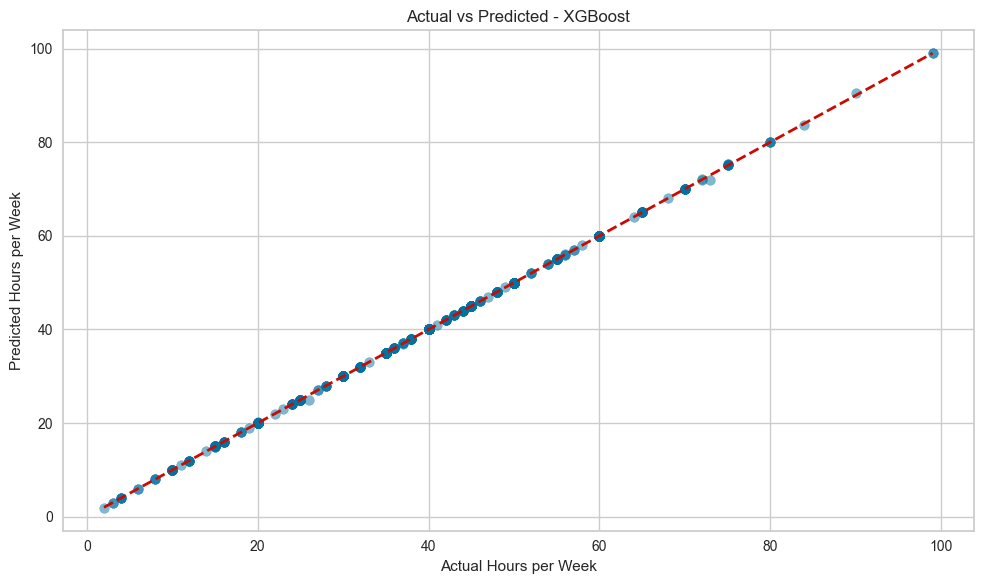

In [3]:
best_model_name = comparison_df.sort_values(by='R^2 Score', ascending=False).iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Train the best model again (or retrieve from loop)
best_model, _ = training.train_model(best_model_name, X_train, y_train, problem_type='regression')
y_pred = best_model.predict(X_test)

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Hours per Week')
plt.ylabel('Predicted Hours per Week')
plt.title(f'Actual vs Predicted - {best_model_name}')

# Save the plot
output_dir = os.path.join('outputs', '04_Full_Regression_Pipeline')
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, 'regression_plot.png')
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
print(f"Plot saved to: {plot_path}")

plt.show()